# Imports

In [11]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.patches as mpatches
from constants import FILE_PATHS_DATA, AXIS_LIMITS, LEGEND_ANCHOR, SPACE_SCALE, X_LABEL, Y_LABEL, Z_LABEL, FLAT_TEXT, \
    EDGE_TEXT, SPHERE_TEXT, NORMALS_TEXT, VECTOR_SCALE, MARKER_SIZE, FORCES_TEXT, TORQUES_TEXT, NUMBER_OF_PLOTS, TIME_STATE_TEXT, \
    FLAT_REF_VEC, EDGE_REF_VEC, SPHERE_REF_VEC, SPHERE_CENTER, NUM_OF_HIS_BINS

%matplotlib widget
import pandas as pd
import numpy as np
from typing import List, Dict, Union, Tuple
import matplotlib.pyplot as plt
from utils import Vector3, COLORS_RGBA, Arrow3D, l2
import json
from data_handler import DataHandler
import os
import imageio
from math import sqrt
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in Data

In [12]:
file_paths = FILE_PATHS_DATA

dhs: List[DataHandler] = []

for fp in file_paths:
	print(file_paths)
	if len(fp) == 0:
		continue
	dhs.append(DataHandler(fp))

if all([fp == "" for fp in file_paths]):
	raise ValueError("Yo I got no paths")


['../data/20230321_092123.json', '../data/20230321_092359.json', '../data/20230321_094445.json', '']
['../data/20230321_092123.json', '../data/20230321_092359.json', '../data/20230321_094445.json', '']
['../data/20230321_092123.json', '../data/20230321_092359.json', '../data/20230321_094445.json', '']
['../data/20230321_092123.json', '../data/20230321_092359.json', '../data/20230321_094445.json', '']


# Configure and Plot Data

In [13]:
def figure_config():
	fig = plt.figure("Tactile Perception Data Presentation", figsize=(15, 10))
	fig.text(*FLAT_TEXT)
	fig.text(*EDGE_TEXT)
	fig.text(*SPHERE_TEXT)
	fig.text(*NORMALS_TEXT, rotation=90)
	fig.text(*FORCES_TEXT, rotation=90)
	fig.text(*TORQUES_TEXT, rotation=90)

	axes = []
	for i in range(1, NUMBER_OF_PLOTS + 1):
		ax = fig.add_subplot(330 + i, projection="3d")
		axes.append(ax)
	return fig, axes

def plot_normals(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			n = Vector3(f.normals[0][i], f.normals[1][i], f.normals[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, n.x, n.y, n.z, color=f.color.color_code, alpha=.8, lw=1)

def plot_forces(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			force = Vector3(f.forces[0][i], f.forces[1][i], f.forces[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, force.x, force.y, force.z, color=f.color.color_code, alpha=1, lw=1)

def plot_torques(ts: DataHandler.TimeState, index: int, axes: List) -> None:
	for f in ts.fingers:
		if f.number_of_contacts == 0:
			continue
		axes[index].scatter3D(f.contact_points[0], f.contact_points[1], f.contact_points[2], color=f.color.color_code, label=f.name_verbose, alpha=1, s=MARKER_SIZE)
		for i in range(f.number_of_contacts):
			cp = Vector3(f.contact_points[0][i], f.contact_points[1][i], f.contact_points[2][i])
			torque = Vector3(f.torques[0][i], f.torques[1][i], f.torques[2][i]).normalize().mul(VECTOR_SCALE)
			axes[index].quiver(cp.x, cp.y, cp.z, torque.x, torque.y, torque.z, color=f.color.color_code, alpha=1, lw=1)

def clear_plots(axes: List):
	for ax in axes:
		ax.clear()
		ax.set_xlabel(X_LABEL)
		ax.set_ylabel(Y_LABEL)
		ax.set_zlabel(Z_LABEL)
		ax.set_xlim(AXIS_LIMITS["x_lim"])
		ax.set_ylim(AXIS_LIMITS["y_lim"])
		ax.set_zlim(AXIS_LIMITS["z_lim"])

def plot_grid(fig,axes):

	time_label = fig.text(0,0,"")

	# for t in [0,1,2,3,4]:
	for t in range(dhs[0].experiment_config.num_of_dp):

		clear_plots(axes)
		time_label.remove()
		time_label = fig.text(*TIME_STATE_TEXT,f"time = {t} s.")

		flat_ts: DataHandler.TimeState   = dhs[0].time_states[t]
		edge_ts: DataHandler.TimeState   = dhs[1].time_states[t]
		sphere_ts: DataHandler.TimeState = dhs[2].time_states[t]

		plot_normals(flat_ts,0,axes)
		plot_forces(flat_ts,3,axes)
		plot_torques(flat_ts,6,axes)

		plot_normals(edge_ts,1,axes)
		plot_forces(edge_ts, 4, axes)
		plot_torques(edge_ts,7,axes)

		plot_normals(sphere_ts,2,axes)
		plot_forces(sphere_ts, 5, axes)
		plot_torques(sphere_ts, 8, axes)
		
		legend_th = mpatches.Patch(color=COLORS_RGBA.MAGENTA.color_code, label='thumb_finger')
		legend_ff = mpatches.Patch(color=COLORS_RGBA.BLUE.color_code, label='first_finger')
		legend_mf = mpatches.Patch(color=COLORS_RGBA.GREEN.color_code, label='middle_finger')
		legend_rf = mpatches.Patch(color=COLORS_RGBA.YELLOW.color_code, label='ring_finger')
		legend_lf = mpatches.Patch(color=COLORS_RGBA.RED.color_code, label='little_finger')
		plt.legend(handles=[legend_th, legend_ff, legend_mf, legend_rf, legend_lf], loc=(1,3.2))
		plt.savefig(f"fig/img/img_{t}.jpg")

# fig, axes = figure_config()

# plot_grid(fig,axes)


# Create GIF from Images Generated Above

In [14]:
def create_gif(data_path: str, save_path: str, num_of_img: int, gif_name: str, fps: int):
	frames = []
	for i in range(num_of_img):
		image = imageio.v2.imread(f"{data_path}img_{i}.jpg")
		frames.append(image)
	imageio.mimsave(f'{save_path}{gif_name}', frames, fps=fps)

fig_dir = "fig/img/"
num_of_images = len([entry for entry in os.listdir(fig_dir) if os.path.isfile(os.path.join(fig_dir, entry))])
# create_gif("fig/img/","fig/",num_of_images, gif_name="sr_tactile_perception_data_visualization.gif", fps=5)

# Calculate Normal Errors

1
ref[0]=(-0.7071067811865475,-0.7071067811865475,0.0), ref[1]=(0.0,-1.0,0.0), ref[2]=(0.7071067811865475,-0.7071067811865475,0.0), n=(0.10311959276653179,0.994668964825818,0.0) [140.91883903982034, 174.08116096017974, 129.0811609601797]
2
ref[0]=(-0.7071067811865475,-0.7071067811865475,0.0), ref[1]=(0.0,-1.0,0.0), ref[2]=(0.7071067811865475,-0.7071067811865475,0.0), n=(0.10311959276653179,0.994668964825818,0.0) [140.91883903982034, 174.08116096017974, 129.0811609601797]
3
ref[0]=(-0.7071067811865475,-0.7071067811865475,0.0), ref[1]=(0.0,-1.0,0.0), ref[2]=(0.7071067811865475,-0.7071067811865475,0.0), n=(-0.7073889759920271,0.7068244737167435,0.0) [89.97712962199012, 134.97712962199014, 179.97712962199944]
4
ref[0]=(-0.7071067811865475,-0.7071067811865475,0.0), ref[1]=(0.0,-1.0,0.0), ref[2]=(0.7071067811865475,-0.7071067811865475,0.0), n=(-0.7073889759920271,0.7068244737167435,0.0) [89.97712962199012, 134.97712962199014, 179.97712962199944]
5
ref[0]=(-0.7071067811865475,-0.7071067811865

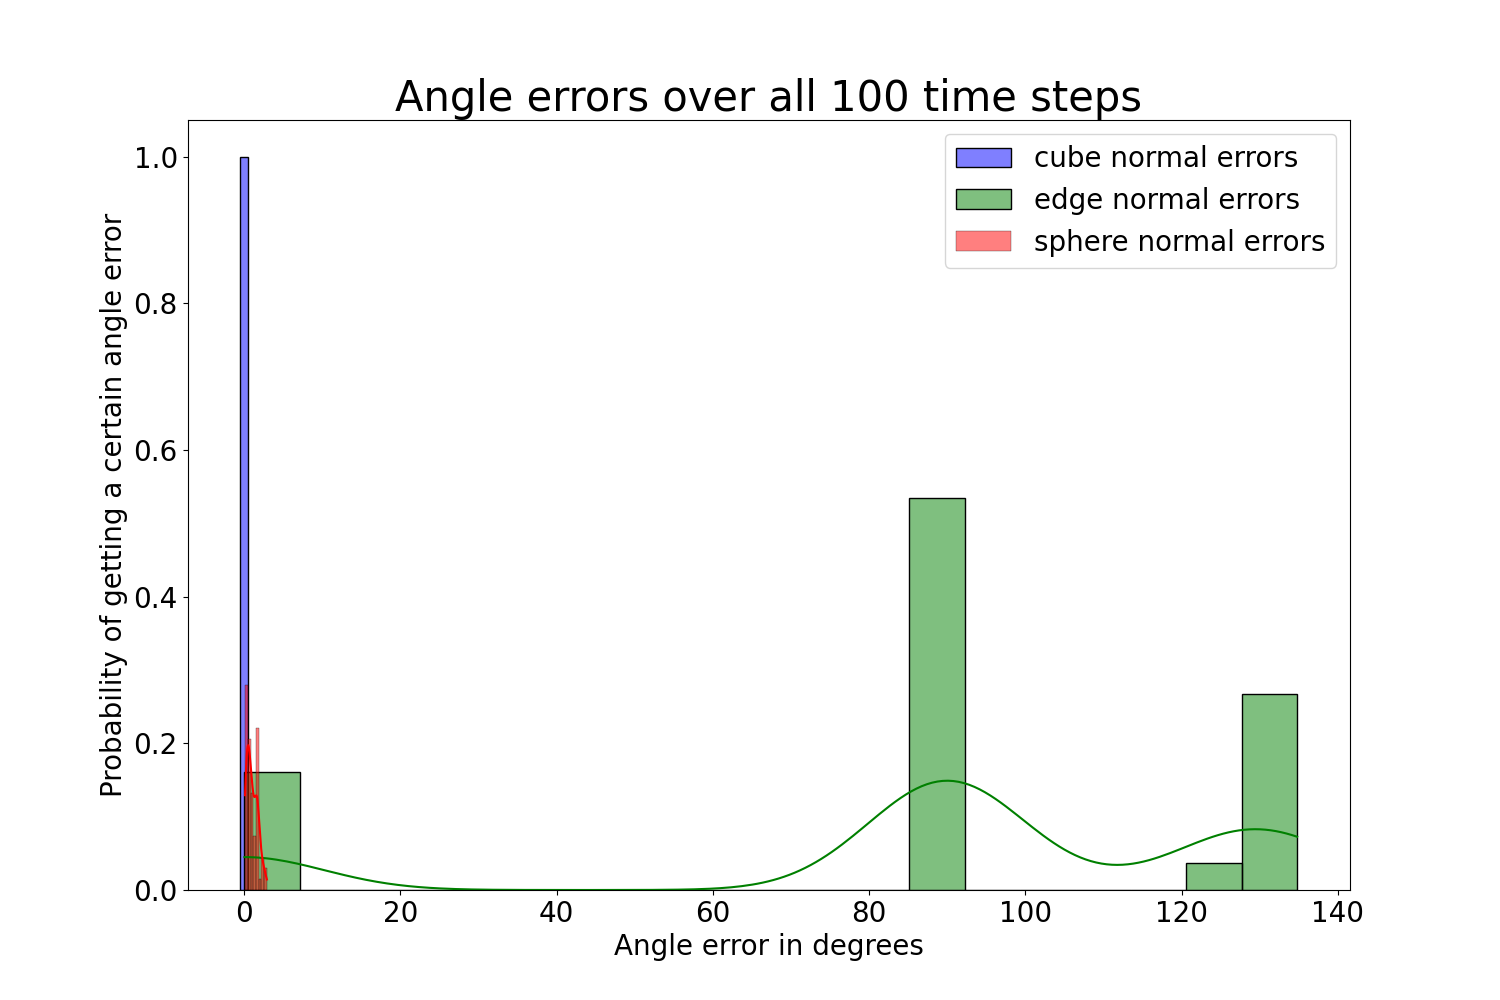

In [15]:

def get_normals(dh: DataHandler) -> List[Vector3]:
	all_normals: List[Vector3] = []
	for t in range(dh.experiment_config.num_of_dp):
		ts: DataHandler.TimeState = dh.time_states[t]
		for f in ts.fingers:
			all_normals.extend(f.normals_vec)
	return all_normals

def get_angle_errors(all_normals: List[Vector3], ref: Union[Tuple[Vector3, Vector3, Vector3],Vector3], dh: DataHandler) -> List[float]:
	# print(dh.experiment_config.prop_name)

	if dh.experiment_config.prop_name == "cube":
		return [ref.angle(n) for n in all_normals]

	elif dh.experiment_config.prop_name == "edge":
		i = 0
		for n in all_normals:
			if abs(n.angle(Vector3(1.0,1.0,1.0))) > 45:
				i += 1
				print(i)
			if min([ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)]) > 20:
				print(f"{ref[0]=}, {ref[1]=}, {ref[2]=}, {n=}", [ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)])
		return [min([ref[0].angle(n), ref[1].angle(n), ref[2].angle(n)]) for n in all_normals]

	elif dh.experiment_config.prop_name == "sphere":
		all_sphere_normals_errors: List[float] = []
		for t in range(dhs[2].experiment_config.num_of_dp):
			sphere_ts: DataHandler.TimeState = dhs[2].time_states[t]
			for f in sphere_ts.fingers:
				for i, cp in enumerate(f.contact_points_vec):
					ref: Vector3 = cp.sub(SPHERE_CENTER).mul(-1.0)
					n: Vector3 = f.normals_vec[i]
					# n: Vector3 = f.normals_vec[i].mul(-1.0)
					e = ref.angle(n)
					all_sphere_normals_errors.append(e)
		return all_sphere_normals_errors
	else:
		print("[ERROR] get_normals did not get a valid prop name, valid prop names include: cube, edge and sphere.")
		return []

def plot_errors(dh: DataHandler, ax):

	plt.title(f"Angle errors over all {dh.experiment_config.num_of_dp} time steps", fontsize=30)
 
	prop_name = dh.experiment_config.prop_name
	color = 0
	normals = get_normals(dh)
	ref = Vector3(1.0, 1.0, 1.0)
	errors = []
	if prop_name == "cube":
		ref = FLAT_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
	elif prop_name == "edge":
		ref = EDGE_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
		color = 1
	elif prop_name == "sphere":
		ref = SPHERE_REF_VEC
		errors = get_angle_errors(normals, ref, dh)
		color = 2
	else:
		return

	colors=["b","g","r"]

	df = pd.DataFrame({f"all_{dh.experiment_config.prop_name}_errors": errors})
	if prop_name == "cube":
		sns.histplot(data=df, ax=ax, stat="probability", label=f"{dh.experiment_config.prop_name} normal errors", palette=[colors[color]])
	else:
		sns.histplot(data=df, ax=ax, stat="probability", label=f"{dh.experiment_config.prop_name} normal errors", palette=[colors[color]] ,kde=True)
	ax.tick_params(axis='both', which='major', labelsize=20)
	ax.set_xlabel("Angle error in degrees", fontsize=20)
	ax.set_ylabel("Probability of getting a certain angle error", fontsize=20)
	plt.legend(fontsize=20)

fig_his, ax_his = plt.subplots()
fig_his.set_figheight(10)
fig_his.set_figwidth(15)

for dh in dhs:
	plot_errors(dh,ax_his)
plt.savefig("fig/sr_tactile_perception_angle_errors.png")

# pull the gnc-and-adapt-master and run from github
# load in PC to matlab
# how to define the problem! - the main problem
	# external sources
	# linear problem - reverse engineer
	# FPFH

# FIX REFERENCES


